# Modèles de machine learning classification

## Objectifs de ce notebook

Dans ce notebook, nous allons tester différents modèles de machine learning pour la prédiction des seuils de promotion:

**Prédiction des classes de délais depuis la date de sortie avant réduction (33%)**

Comparaison des performances de plusieurs modèles
- **Random forest**
- **XGBoost**

## Données utilisées

Utilisation du fichier nettoyé dataset jeux ps5 avec travail sur les features réalisé: **featured_games_dataset_final.csv**.

- modélisation avec les données de bases
- modélisation avec les données après feature engineering

## Note sur les librairies utilisées

Ce notebook utilise scikit learn pour la partie machine learning

## Import des librairies

In [246]:
# Python base
import sys
from pathlib import Path
import os

# Bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    BayesianRidge,
    HuberRegressor,
    RANSACRegressor,
    Lars,
    LassoLars,
    OrthogonalMatchingPursuit,
)
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
    BaggingRegressor,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

## Méthodes utiles

In [247]:
def column_summary(df: pd.DataFrame):
    summary = []
    for col in df.columns:
        col_type = df[col].dtype
        non_null = df[col].notna().sum()
        null_count = df[col].isna().sum()
        
        # Gérer le cas où la colonne contient des listes (unhashable)
        try:
            unique_count = df[col].nunique()
        except TypeError:
            # Si erreur (listes), convertir en string temporairement
            unique_count = df[col].astype(str).nunique()
            print(f"⚠️ Colonne '{col}' contient des types non-hashable (probablement des listes)")

        summary.append({
            'Column': col,
            'Type': str(col_type),
            'Non-Null Count': non_null,
            'Null Count': null_count,
            'Unique Values': unique_count,
        })

    # Afficher le résumé des colonnes
    print("=" * 80)
    print("Résumé détaillé des colonnes:")
    print("=" * 80)
    column_summary_df = pd.DataFrame(summary)
    print(column_summary_df.to_string(index=False))
    print("\n")

In [248]:
class OutlierClipper(BaseEstimator, TransformerMixin):
    """Clip les outliers avec la méthode IQR"""
    
    def __init__(self):
        self.lower_bounds_ = None
        self.upper_bounds_ = None
    
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_values = X.values
        else:
            X_values = X
        
        Q1 = np.percentile(X_values, 25, axis=0)
        Q3 = np.percentile(X_values, 75, axis=0)
        IQR = Q3 - Q1
        
        self.lower_bounds_ = Q1 - 1.5 * IQR
        self.upper_bounds_ = Q3 + 1.5 * IQR
        
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X_values = X.values
            X_clipped = np.clip(X_values, self.lower_bounds_, self.upper_bounds_)
            return pd.DataFrame(X_clipped, columns=X.columns, index=X.index)
        else:
            return np.clip(X, self.lower_bounds_, self.upper_bounds_)

In [249]:
class ZeroImputer(BaseEstimator, TransformerMixin):
    """Impute les valeurs manquantes par 0"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.fillna(0)
        else:
            # Si numpy array
            X_copy = X.copy()
            X_copy[np.isnan(X_copy)] = 0
            return X_copy

## Chargement des données

In [250]:
path = os.path.join(Path.cwd().parent, "data/processed")

In [251]:
# Charger les données CSV pour verifier
df_dataset = pd.read_csv(os.path.join(path, "featured_games_dataset_final.csv"))

In [252]:
column_summary(df_dataset)

Résumé détaillé des colonnes:
                                 Column    Type  Non-Null Count  Null Count  Unique Values
                               id_store  object            5382           0           5382
                  pssstore_stars_rating float64            5382           0            352
            pssstore_stars_rating_count   int64            5382           0           1583
                metacritic_critic_score float64            1268        4114             67
                                 is_ps4   int64            5382           0              2
                               is_indie   int64            5382           0              2
                                 is_dlc   int64            5382           0              1
                                  is_vr   int64            5382           0              2
                        is_opti_ps5_pro   int64            5382           0              2
                            is_remaster   int64            5

In [253]:
df_dataset.head()

,id_store,pssstore_stars_rating,pssstore_stars_rating_count,metacritic_critic_score,is_ps4,is_indie,is_dlc,is_vr,is_opti_ps5_pro,is_remaster,...,content_category,exclusif_playstation_content,visibility_score,visibility_category,pegi_unified,price_category,game_age_years,month_sin,month_cos,release_season
0,EP8311-PPSA19174_00-0421646910657705,1.57,14,NaN,0,0,0,0,0,0,...,minimal,0,7.0,obscure,7,0 - 7.99,2,-8.660254e-01,0.500000,fall
1,EP2005-PPSA06055_00-SINUCA0000000000,3.26,72,NaN,0,0,0,0,0,0,...,minimal,0,43.0,moderate,3,0 - 7.99,3,5.000000e-01,-0.866025,spring
2,EP8311-PPSA16513_00-0233078860249892,1.55,11,NaN,0,0,0,0,0,0,...,minimal,0,7.0,obscure,3,0 - 7.99,2,5.000000e-01,-0.866025,spring
3,EP8311-PPSA13840_00-0277389480637871,1.44,18,NaN,0,0,0,0,0,0,...,minimal,0,8.0,obscure,3,0 - 7.99,2,5.000000e-01,0.866025,winter
4,EP8311-PPSA12662_00-0212989199890961,1.17,23,NaN,0,0,0,0,0,0,...,minimal,0,8.0,obscure,3,0 - 7.99,3,-2.449294e-16,1.000000,winter


## Rappel des features disponibles

In [254]:
# 47 features au total

# X Basic features simple sans traitement avancés (28)

# base_price                    - numeric (float)
# pssstore_stars_rating_count   - numeric (int)
# pssstore_stars_rating         - numeric (float)
# is_indie                      - boolean
# has_microtransactions         - boolean
# dlcs_count                        - numeric (int)
# packs_deluxe_count            - numeric (int)
# series_count                   - numeric (int)
# trophies_count                - numeric (int)
# is_vr                         - boolean
# has_local_multiplayer         - boolean
# has_online_multiplayer        - boolean
# is_online_only                - boolean
# is_opti_ps5_pro               - boolean
# is_ps_exclusive               - boolean
# difficulty                    - numeric (int)
# is_remaster                   - boolean
# is_ps4                        - boolean
# pegi_unified                  - category (numeric)
# metacritic_critic_score       - numeric (float)
# hours_main_story              - numeric (float)
# voice_languages_count        - numeric (int)
# sub_languages_count           - numeric (int)
# download_size_gb              - numeric (float)
# price_category                - category



#  X Advanced features engineered (19)

# popularity_score              - numeric (float)
# popularity_category           - category
# visibility_score              - numeric (float)
# visibility_category           - category
# exclusif_playstation_content  - boolean
# publisher_game_count          - numeric (int)
# publisher_game_count_cat      - category
# publisher_category            - category
# genre_action_aventure         - boolean
# genre_roles                   - boolean
# genre_sports                  - boolean
# genre_reflexion               - boolean
# genre_rapide                  - boolean
# localization_category         - category
# download_size_category        - category
# content_score                 - numeric (float)
# content_category              - category
# game_age_years                - numeric (int)
# month_sin                     - numeric (float)
# month_cos                     - numeric (float)
# release_season                - category


#  X Bonus observations à + 60 jours (2)

# has_5pct_discount_at_30d      - boolean
# has_10pct_discount_at_60d     - boolean

# Y
# 
# Regression nombre de jours
# 
# days_to_10_percent_discount - numeric (int)
# days_to_25_percent_discount - numeric (int)
# days_to_33_percent_discount - numeric (int)
# days_to_50_percent_discount - numeric (int)
# days_to_75_percent_discount - numeric (int)

# Classification tranche délais avant promotion

# Classification binaires:

# has_33_percent_discount_before_0.6_year
# has_50_percent_discount_before_1_year
# has_75_percent_discount_before_3_year
# 
# Classification multiples:

# days_to_10_percent_discount_category - category
# days_to_25_percent_discount_category - category
# days_to_33_percent_discount_category - category
# days_to_50_percent_discount_category - category
# days_to_75_percent_discount_category - category

## Combinaison de features

In [255]:
# Feature de base sans feature engeniering avancés
base_features = {
    "numeric_continuous": [
        "base_price",
        "hours_main_story",
        "download_size_gb",
    ],
    "numeric_discrete_zero": [
        "packs_deluxe_count",
        "series_count",
        "sub_languages_count",
        "voice_languages_count",
        "dlcs_count",
        "game_age_years",
    ],
    "numeric_discrete_median": [
        "trophies_count",
    ],
    "boolean_cols": [
        "is_indie",
        "is_vr",
        "is_ps_exclusive",
        "is_remaster",
        "is_ps4",
        "has_local_multiplayer",
        "has_online_multiplayer",
        "is_online_only",
        "has_microtransactions",
        "is_opti_ps5_pro",
        "genre_action_aventure",
        "genre_roles",
        "genre_sports",
        "genre_reflexion",
        "genre_rapide",
    ],
    "categorical_cols": [
        "release_season",
    ],
    "ordinal_cols": ["difficulty", "pegi_unified"],
    "passthrough_cols": ["month_sin", "month_cos"],
}

# Feature de base sans feature engeniering avancés + données disponible + 60j après sortie
base_features_post_release = {
    "numeric_continuous": [
        "base_price",
        "hours_main_story",
        "download_size_gb",
        "pssstore_stars_rating",  # Observation post sortie
        "metacritic_critic_score",  # Observation post sortie
    ],
    "numeric_discrete_zero": [
        "packs_deluxe_count",
        "series_count",
        "sub_languages_count",
        "voice_languages_count",
        "dlcs_count",
        "game_age_years",
    ],
    "numeric_discrete_median": [
        "trophies_count",
        "pssstore_stars_rating_count",  # Observation post sortie
    ],
    "boolean_cols": [
        "is_indie",
        "is_vr",
        "is_ps_exclusive",
        "is_remaster",
        "is_ps4",
        "has_local_multiplayer",
        "has_online_multiplayer",
        "is_online_only",
        "has_microtransactions",
        "is_opti_ps5_pro",
        "genre_action_aventure",
        "genre_roles",
        "genre_sports",
        "genre_reflexion",
        "genre_rapide",
        "has_5pct_discount_at_30d",  # Observation post sortie
        "has_10pct_discount_at_60d",  # Observation post sortie
    ],
    "categorical_cols": [
        "release_season",
    ],
    "ordinal_cols": ["difficulty", "pegi_unified"],
    "passthrough_cols": ["month_sin", "month_cos"],
}

# Feature de base + Feature engeniering avancés
all_features = {
    "numeric_continuous": [
        "base_price",
        "hours_main_story",
        "download_size_gb",
    ],
    "numeric_discrete_zero": [
        "packs_deluxe_count",
        "series_count",
        "sub_languages_count",
        "voice_languages_count",
        "publisher_game_count",
        "dlcs_count",
        "game_age_years",
    ],
    "numeric_discrete_median": [
        "trophies_count",
    ],
    "boolean_cols": [
        "is_indie",
        "is_vr",
        "is_ps_exclusive",
        "is_remaster",
        "is_ps4",
        "has_local_multiplayer",
        "has_online_multiplayer",
        "is_online_only",
        "has_microtransactions",
        "is_opti_ps5_pro",
        "exclusif_playstation_content", #advanced
        "genre_action_aventure",
        "genre_roles",
        "genre_sports",
        "genre_reflexion",
        "genre_rapide",
    ],
    "categorical_cols": [
        "price_category",
        "publisher_category",
        "visibility_category", # advanced
        "content_category", # advanced
        "download_size_category",
        "localization_category",
        "publisher_game_count_cat",
        "release_season",
    ],
    "ordinal_cols": ["difficulty", "pegi_unified"],
    "score_cols": ["visibility_score", "content_score"], #advanced
    "passthrough_cols": ["month_sin", "month_cos"],
}

# Feature de base + Feature engeniering avancés + données disponible 60j après sortie
all_features_post_release = {
    "numeric_continuous": [
        "base_price",
        "pssstore_stars_rating",  # Observation post sortie
        "metacritic_critic_score",  # Observation post sortie
        "hours_main_story",
        "download_size_gb",
    ],
    "numeric_discrete_zero": [
        "packs_deluxe_count",
        "series_count",
        "sub_languages_count",
        "voice_languages_count",
        "publisher_game_count",
        "dlcs_count",
        "game_age_years",
    ],
    "numeric_discrete_median": [
        "pssstore_stars_rating_count",  # Observation post sortie
        "trophies_count",
    ],
    "boolean_cols": [
        "is_indie",
        "is_vr",
        "is_ps_exclusive",
        "is_remaster",
        "is_ps4",
        "has_local_multiplayer",
        "has_online_multiplayer",
        "is_online_only",
        "has_microtransactions",
        "is_opti_ps5_pro",
        "exclusif_playstation_content", #advanced
        "has_5pct_discount_at_30d",  # Observation post sortie
        "has_10pct_discount_at_60d",  # Observation post sortie
        "genre_action_aventure",
        "genre_roles",
        "genre_sports",
        "genre_reflexion",
        "genre_rapide",
    ],
    "categorical_cols": [
        "price_category",
        "publisher_category",
        "visibility_category", # advanced
        "popularity_category",  # Observation post sortie
        "content_category", # advanced
        "download_size_category",
        "localization_category",
        "publisher_game_count_cat",
        "release_season",
    ],
    "ordinal_cols": ["difficulty", "pegi_unified"],
    "score_cols": ["popularity_score", "visibility_score", "content_score"], #advanced
    "passthrough_cols": ["month_sin", "month_cos"],
}


# 1. BASE + Prix uniquement (focus économique)
base_features_price_focus = {
    **base_features,
    "categorical_cols": base_features["categorical_cols"] + [
        "price_category",
        "publisher_category"
    ]
}

# 2. BASE + Qualité uniquement (focus contenu)
base_features_quality_focus = {
    **base_features,
    "score_cols": ["content_score"],
    "categorical_cols": base_features["categorical_cols"] + [
        "content_category",
        "download_size_category"
    ]
}

# 3. BASE + Visibilité uniquement (focus marketing)
base_features_visibility_focus = {
    **base_features,
    "score_cols": ["visibility_score"],
    "categorical_cols": base_features["categorical_cols"] + [
        "visibility_category",
        "publisher_game_count_cat"
    ]
}

# 4. BASE + Toutes catégories (sans scores)
base_features_with_categories = {
    **base_features,
    "categorical_cols": [
        "release_season",
        "price_category",
        "publisher_category",
        "visibility_category",
        "content_category",
        "download_size_category",
        "localization_category",
        "publisher_game_count_cat"
    ]
}

# 5. BASE + Tous scores (sans catégories)
base_features_with_scores = {
    **base_features,
    "score_cols": ["visibility_score", "content_score"]
}

# 6. POST_RELEASE minimal (ratios early discount)
minimal_post_release = {
    **base_features,
    "boolean_cols": base_features["boolean_cols"] + [
        "has_5pct_discount_at_30d",
        "has_10pct_discount_at_60d"
    ]
}

# 7. POST_RELEASE + Popularity uniquement
post_release_popularity_only = {
    **base_features_post_release,
    "score_cols": ["popularity_score"],
    "categorical_cols": base_features_post_release["categorical_cols"] + [
        "popularity_category"
    ]
}

feature_sets = {
    # Baseline
    "1_base": base_features,
    
    # Incrémental par thème
    "2_base+price": base_features_price_focus,
    "3_base+quality": base_features_quality_focus,
    "4_base+visibility": base_features_visibility_focus,
    
    # Toutes engineered
    "5_base+all_cats": base_features_with_categories,
    "6_base+all_scores": base_features_with_scores,
    "7_all": all_features,
    
    # Post-release
    "8_post_minimal": minimal_post_release,
    "9_post_base": base_features_post_release,
    "10_post_all": all_features_post_release,
}

In [256]:
def get_all_features_columns(features_dict):
    all_columns = []
    for feature_list in features_dict.values():
        all_columns.extend(feature_list)
    return all_columns

### En attente de tests

In [257]:
# pssstore_stars_rating_count (0 à 1.8M) → log transform pour réduire l'échelle

## Preprocessing

1. Numériques continues → Imputation + Scaling (si nécessaire)
2. Numériques discrètes → Imputation + Binning ou Sqrt (optionnel)
3. Booléennes → Format 0/1
4. Ordinales → Garder l'ordre naturel
5. Nominales → Label Encoding (Modèles Arbres)

### Pipeline preprocessing sci kit learn

In [258]:
def create_pipeline(model_type: str, available_columns: dict):
    """
    Crée un Pipeline sklearn pour le preprocessing, Type de modèle : 'tree', 'linear', 'svm'
        X_train_processed = pipeline.fit_transform(X_train)
        X_test_processed = pipeline.transform(X_test)
    """
    # Liste pour stocker tous les transformers
    transformers = []

    # NUMÉRIQUES CONTINUES
    filtered_numeric_continuous = available_columns.get("numeric_continuous", [])

    if model_type == "tree":
        # TREE: Juste imputation, pas de scaling
        numeric_continuous_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median"))]
        )

    elif model_type == "linear":
        # LINEAR: Imputation + Outliers + Standardisation
        numeric_continuous_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("outlier_clipper", OutlierClipper()),
                ("scaler", StandardScaler()),
            ]
        )

    elif model_type == "svm":
        # SVM: Imputation + Outliers + Normalisation [0,1]
        numeric_continuous_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("outlier_clipper", OutlierClipper()),
                ("scaler", MinMaxScaler()),
            ]
        )

    if filtered_numeric_continuous is not None and len(filtered_numeric_continuous) > 0:
        transformers.append(
            (
                "num_continuous",
                numeric_continuous_transformer,
                filtered_numeric_continuous,
            )
        )

    # NUMERIQUES DISCRETES zéro
    numeric_discrete_zero = available_columns.get("numeric_discrete_zero", [])

    if model_type == "tree":
        numeric_discrete_zero_transformer = Pipeline(
            steps=[("zero_imputer", ZeroImputer())]
        )
    elif model_type == "linear":
        numeric_discrete_zero_transformer = Pipeline(
            steps=[("zero_imputer", ZeroImputer()), ("scaler", StandardScaler())]
        )
    elif model_type == "svm":
        numeric_discrete_zero_transformer = Pipeline(
            steps=[("zero_imputer", ZeroImputer()), ("scaler", MinMaxScaler())]
        )

    if numeric_discrete_zero is not None and len(numeric_discrete_zero) > 0:
        transformers.append(
            (
                "num_discrete_zero",
                numeric_discrete_zero_transformer,
                numeric_discrete_zero,
            )
        )

    # NUMERIQUES DISCRETES médiane
    numeric_discrete_median = available_columns.get("numeric_discrete_median", [])

    if model_type == "tree":
        numeric_discrete_median_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median"))]
        )
    elif model_type == "linear":
        numeric_discrete_median_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )
    elif model_type == "svm":
        numeric_discrete_median_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", MinMaxScaler()),
            ]
        )

    if numeric_discrete_median is not None and len(numeric_discrete_median) > 0:
        transformers.append(
            (
                "num_discrete_median",
                numeric_discrete_median_transformer,
                numeric_discrete_median,
            )
        )

    # BOOLÉENNES
    boolean_cols = available_columns.get("boolean_cols", [])
    boolean_transformer = Pipeline(
        steps=[("zero_imputer", ZeroImputer())]  # Remplacer NA par 0
    )

    if boolean_cols is not None and len(boolean_cols) > 0:
        transformers.append(("boolean", boolean_transformer, boolean_cols))

    # CATÉGORIELLES
    categorical_cols = available_columns.get("categorical_cols", [])

    if model_type == "tree":
        # TREE Label Encoding (via OrdinalEncoder)
        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
                (
                    "encoder",
                    OrdinalEncoder(
                        handle_unknown="use_encoded_value",
                        unknown_value=-1,
                        encoded_missing_value=-1,
                    ),
                ),
            ]
        )
    else:
        # LINEAR / SVM: One-Hot Encoding
        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
                (
                    "encoder",
                    OneHotEncoder(
                        drop="first", sparse_output=False, handle_unknown="ignore"
                    ),
                ),
            ]
        )

    if categorical_cols is not None and len(categorical_cols) > 0:
        transformers.append(("categorical", categorical_transformer, categorical_cols))

    # ORDINALES
    ordinal_cols = available_columns.get("ordinal_cols", [])

    if model_type == "tree":
        ordinal_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median"))]
        )
    else:  # linear ou svm
        ordinal_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )

    if len(ordinal_cols) > 0:
        transformers.append(("ordinal", ordinal_transformer, ordinal_cols))

    # SCORES ENGINEERED
    score_cols = available_columns.get("score_cols", [])

    score_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),  # Recommandé pour tous les modèles
        ]
    )

    if score_cols is not None and len(score_cols) > 0:
        transformers.append(("scores", score_transformer, score_cols))

    # Colonnes Déjà normalisées, juste passer tel quel
    pass_cols = available_columns.get("passthrough_cols", [])
    pass_transformer = "passthrough"

    if pass_cols is not None and len(pass_cols) > 0:
        transformers.append(("pass", pass_transformer, pass_cols))

    # PIPELINE FINAL
    pipeline = Pipeline(
        steps=[
            (
                "preprocessor",
                ColumnTransformer(
                    transformers=transformers,
                    remainder="drop",  # Supprimer les colonnes non spécifiées
                    verbose_feature_names_out=False,  # Garder noms courts
                ),
            )
        ]
    )

    print(f"Pipeline {model_type.upper()} créé avec {len(transformers)} groupes de transformers")

    return pipeline

In [259]:
def save_pipeline(pipeline, filepath):
    """
    Sauvegarde le pipeline
    """
    import joblib
    joblib.dump(pipeline, filepath)
    print(f"✅ Pipeline sauvegardé : {filepath}")

In [260]:
def load_pipeline(filepath):
    """
    Charge un pipeline sauvegardé
    """
    import joblib
    pipeline = joblib.load(filepath)
    print(f"✅ Pipeline chargé : {filepath}")
    return pipeline

In [261]:
def create_pipelines(X_train, X_test,available_columns: dict):
    pipeline_types = ['tree', 'linear', 'svm']
    pipelines = {}
    X_train_processed = {}
    X_test_processed = {}

    for t in pipeline_types:
        # Créer pipeline
        pipelines[t] = create_pipeline(model_type=t, available_columns=available_columns)
        
        # Fit et transform
        X_train_processed[t] = pipelines[t].fit_transform(X_train)
        X_test_processed[t] = pipelines[t].transform(X_test)

    return pipelines, X_train_processed, X_test_processed

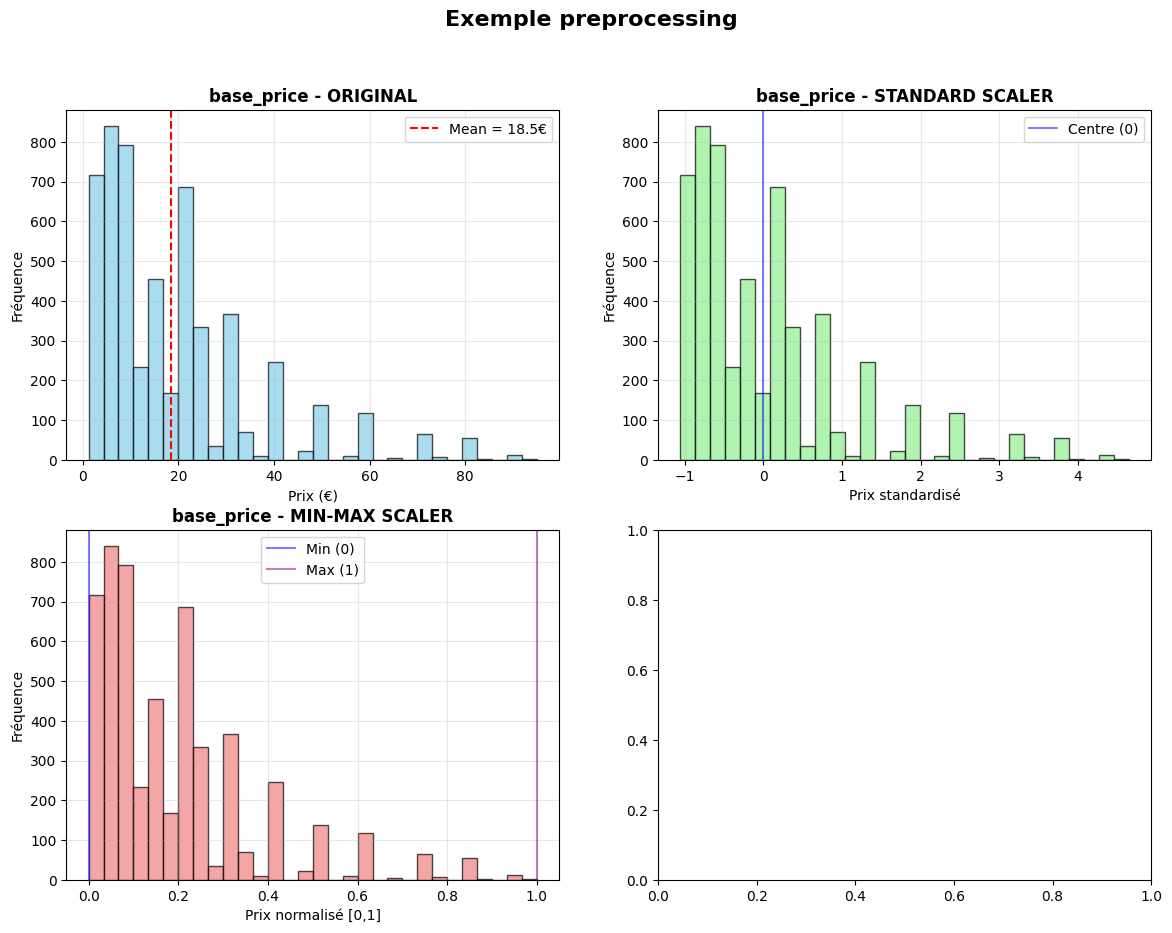

In [262]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Exemple preprocessing', fontsize=16, fontweight='bold')

# Colonne prix réelle
price_col = 'base_price'
if price_col in df_dataset.columns:
    price_data = df_dataset[price_col].dropna()
    
    # Original
    ax = axes[0, 0]
    ax.hist(price_data, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(f'{price_col} - ORIGINAL', fontweight='bold')
    ax.set_xlabel('Prix (€)')
    ax.set_ylabel('Fréquence')
    ax.axvline(price_data.mean(), color='red', linestyle='--', label=f'Mean = {price_data.mean():.1f}€')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # StandardScaler
    scaler_std = StandardScaler()
    price_std = scaler_std.fit_transform(price_data.values.reshape(-1, 1))
    
    ax = axes[0, 1]
    ax.hist(price_std, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
    ax.set_title(f'{price_col} - STANDARD SCALER', fontweight='bold')
    ax.set_xlabel('Prix standardisé')
    ax.set_ylabel('Fréquence')
    ax.axvline(0, color='blue', linestyle='-', alpha=0.5, label='Centre (0)')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # MinMaxScaler
    scaler_mm = MinMaxScaler()
    price_mm = scaler_mm.fit_transform(price_data.values.reshape(-1, 1))
    
    ax = axes[1, 0]
    ax.hist(price_mm, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
    ax.set_title(f'{price_col} - MIN-MAX SCALER', fontweight='bold')
    ax.set_xlabel('Prix normalisé [0,1]')
    ax.set_ylabel('Fréquence')
    ax.axvline(0, color='blue', linestyle='-', alpha=0.5, label='Min (0)')
    ax.axvline(1, color='purple', linestyle='-', alpha=0.5, label='Max (1)')
    ax.legend()
    ax.grid(alpha=0.3)

## Premier Tests sur classification binaire 50% réduction avant 1 an

In [263]:
df_binary_disc = df_dataset.copy()

In [264]:
# has_33_percent_discount_before_0.6_year
# has_50_percent_discount_before_1_year
# has_75_percent_discount_before_3_year

TARGET_PROMO_BINNARY_COL = 'has_75_percent_discount_before_3_year'
FEATURES_TO_USE = base_features

### Nettoyage des données qui ne possèdent pas la target (None)

In [265]:
# On supprime les lignes (jeux récent n'ayant jamais ateind la promotion)
df_binary_disc = df_binary_disc.dropna(subset=[TARGET_PROMO_BINNARY_COL])

print(df_binary_disc[TARGET_PROMO_BINNARY_COL].value_counts())

print(f"Avant: {len(df_dataset)} lignes")
print(f"Après: {len(df_binary_disc)} lignes")

has_75_percent_discount_before_3_year
1.0    964
0.0    799
Name: count, dtype: int64
Avant: 5382 lignes
Après: 1763 lignes


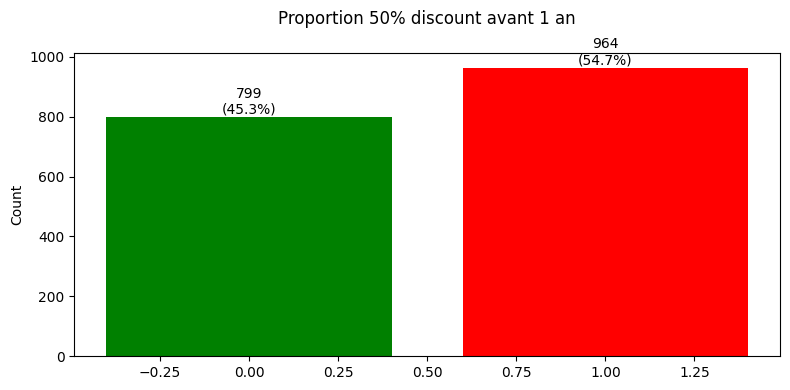

In [266]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

counts = df_binary_disc[TARGET_PROMO_BINNARY_COL].value_counts()
ax : plt.Axes
bars = ax.bar(counts.index, counts.values, color=['red', 'green'])
ax.set_title('Proportion 50% discount avant 1 an\n')
ax.set_ylabel('Count')

# Ajouter pourcentages
for bar in bars:
    height = bar.get_height()
    pct = height / len(df_binary_disc[TARGET_PROMO_BINNARY_COL]) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({pct:.1f}%)',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Récupération des features de base

In [267]:
base_X_features = get_all_features_columns(FEATURES_TO_USE)

# Sélectionner les colonnes disponibles
X = df_binary_disc[base_X_features]

# On assigne la target
y = df_binary_disc[TARGET_PROMO_BINNARY_COL]

### Création train test split

In [268]:
# Encoder les catégories en nombres
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  
)

print(f"\nTrain : {len(X_train)} | Test : {len(X_test)}")
print("\nDistribution classes (train) :")


Train : 1410 | Test : 353

Distribution classes (train) :


In [269]:
pipelines, X_train_dict, X_test_dict = create_pipelines(X_train, X_test,available_columns=FEATURES_TO_USE)

for t, pipeline in pipelines.items():
    print(f"\n{t.upper()} Train processed : {X_train_dict[t].shape}")
    print(f"{t.upper()} Test processed  : {X_test_dict[t].shape}")

Pipeline TREE créé avec 7 groupes de transformers
Pipeline LINEAR créé avec 7 groupes de transformers
Pipeline SVM créé avec 7 groupes de transformers

TREE Train processed : (1410, 30)
TREE Test processed  : (353, 30)

LINEAR Train processed : (1410, 32)
LINEAR Test processed  : (353, 32)

SVM Train processed : (1410, 32)
SVM Test processed  : (353, 32)


In [270]:
# 6.1 Gridesearch pour hyperparamètres
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold


print("\n=== GRIDS SEARCH POUR HYPERPARAMÈTRES ===")
# Définition du modèle de base
model = RandomForestClassifier(random_state=42)
# Définition des hyperparamètres à tester
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

# Configuration de la validation croisée
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold cross-validation
# Grille de recherche
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='accuracy', cv=cv_strategy, n_jobs=-1, verbose=2)

# Entraînement du modèle avec GridSearch
grid_search.fit(X_train_dict['tree'], y_train)

# Meilleurs hyperparamètres
print("\nMeilleurs hyperparamètres trouvés:")
print(grid_search.best_params_)

# Meilleur score
print(f"Meilleur score de validation: {grid_search.best_score_:.2%}")
# Entraînement du modèle avec les meilleurs hyperparamètres
best_model = grid_search.best_estimator_


=== GRIDS SEARCH POUR HYPERPARAMÈTRES ===
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=

In [ ]:
# CRÉATION DU MODÈLE COMPLET (Pipeline + ML)
print("\n=== CRÉATION DU MODÈLE ===")

# Pipeline complet: preprocessing + modèle
model_pipeline = Pipeline(steps=[
    ('preprocessor', pipelines['tree'].named_steps['preprocessor']),
    #('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ('classifier', best_model)
])


=== CRÉATION DU MODÈLE ===


In [272]:
# CROSS-VALIDATION
from sklearn.model_selection import cross_val_score


print("\n=== CROSS-VALIDATION ===")

# Configuration de la cross-validation stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scores de cross-validation
cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=cv, scoring='accuracy')

print(f"Scores CV: {cv_scores}")
print(f"Score CV moyen: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


=== CROSS-VALIDATION ===
Scores CV: [0.81560284 0.84397163 0.78368794 0.79432624 0.80496454]
Score CV moyen: 0.8085 (+/- 0.0414)


## Premier tests de prédictions Classification multiple

In [273]:
df_clean = df_dataset.copy()

### Choisir la target: niveau de promotion

In [274]:
TARGET_PROMO_COL = 'days_to_50_percent_discount_category'
FEATURES_TO_USE = all_features_post_release
RECENT_GAMES_NO_DISCOUNT_CAT = 'moins_de_2_ans_sans_baisse'

### Nettoyage des données qui ne possèdent pas la target

In [275]:
# On supprime les lignes (jeux récent n'ayant jamais ateind la promotion)
df_clean = df_clean[df_clean[TARGET_PROMO_COL] != RECENT_GAMES_NO_DISCOUNT_CAT]

print(df_clean[TARGET_PROMO_COL].value_counts())

print(f"Avant: {len(df_dataset)} lignes")
print(f"Après: {len(df_clean)} lignes")

days_to_50_percent_discount_category
6-12_mois         1216
1-2_ans            702
3-6_mois           592
jamais_ou_plus     576
0-3_mois           449
Name: count, dtype: int64
Avant: 5382 lignes
Après: 3535 lignes


### Récupération des features de base

In [276]:
base_X_features = get_all_features_columns(FEATURES_TO_USE)

# Sélectionner colonnes disponibles
X = df_clean[base_X_features]

# On assigne la target
y = df_clean[TARGET_PROMO_COL]

### Vérification des colonnes 

In [277]:
column_summary(X)

Résumé détaillé des colonnes:
                      Column    Type  Non-Null Count  Null Count  Unique Values
                  base_price float64            3535           0             61
       pssstore_stars_rating float64            3535           0            318
     metacritic_critic_score float64             949        2586             65
            hours_main_story float64            2463        1072             85
            download_size_gb float64            1875        1660            784
          packs_deluxe_count   int64            3535           0              9
                series_count   int64            3535           0             24
         sub_languages_count float64            2539         996             31
       voice_languages_count float64            1707        1828             17
        publisher_game_count   int64            3535           0             52
                  dlcs_count   int64            3535           0             54
          

### Création train test split

In [278]:
# Encoder les catégories en nombres
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  
)

print(f"\nTrain : {len(X_train)} | Test : {len(X_test)}")
print("\nDistribution classes (train) :")


Train : 2828 | Test : 707

Distribution classes (train) :


### Creation des pipelines preprocess

In [279]:
pipelines, X_train_dict, X_test_dict = create_pipelines(X_train, X_test,available_columns=FEATURES_TO_USE)

for t, pipeline in pipelines.items():
    print(f"\n{t.upper()} Train processed : {X_train_dict[t].shape}")
    print(f"{t.upper()} Test processed  : {X_test_dict[t].shape}")

Pipeline TREE créé avec 8 groupes de transformers
Pipeline LINEAR créé avec 8 groupes de transformers
Pipeline SVM créé avec 8 groupes de transformers

TREE Train processed : (2828, 48)
TREE Test processed  : (707, 48)

LINEAR Train processed : (2828, 76)
LINEAR Test processed  : (707, 76)

SVM Train processed : (2828, 76)
SVM Test processed  : (707, 76)


### TODO : Afficher données preprocessed
### TODO : test avec target standard scaler

### Métriques d'évaluation

- precision    
- recall  
- f1-score

### Random forest Classifier

In [280]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Modèle
rf_clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    class_weight='balanced',  # pour classes déséquilibrées
    random_state=42,
    n_jobs=-1
)

# Entraîner
rf_clf.fit(X_train_dict['tree'], y_train)

# Prédire
predictions = rf_clf.predict(X_test_dict['tree'])

# Évaluer
print(f"Accuracy : {accuracy_score(y_test, predictions):.3f}")
print("\n" + classification_report(y_test, predictions))

Accuracy : 0.491

              precision    recall  f1-score   support

           0       0.55      0.51      0.53        90
           1       0.35      0.48      0.40       141
           2       0.40      0.18      0.25       118
           3       0.55      0.64      0.59       243
           4       0.60      0.50      0.55       115

    accuracy                           0.49       707
   macro avg       0.49      0.46      0.46       707
weighted avg       0.49      0.49      0.48       707



In [281]:
from xgboost import XGBClassifier

# Modèle
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softmax',  # ⭐ Classification multiclasse
    num_class=6,                # ⭐ 6 catégories
    random_state=42,
    n_jobs=-1
)

# Entraîner
xgb_clf.fit(X_train_dict['tree'], y_train)

# Prédire
predictions = xgb_clf.predict(X_test_dict['tree'])

# Évaluer
print(f"Accuracy : {accuracy_score(y_test, predictions):.3f}")
print("\n" + classification_report(y_test, predictions))

Accuracy : 0.477

              precision    recall  f1-score   support

           0       0.56      0.41      0.47        90
           1       0.34      0.36      0.35       141
           2       0.38      0.18      0.24       118
           3       0.51      0.68      0.58       243
           4       0.56      0.55      0.56       115

    accuracy                           0.48       707
   macro avg       0.47      0.44      0.44       707
weighted avg       0.47      0.48      0.46       707



### TODO

In [282]:
# KNN amputation
# Cross validation
# Classification binaire

## Automatiser démarche empirique

Création d'un système permettant de lancer une bibliothèque de modèles sur plusieurs combinaisons de features et plusieurs target de prédictions.

In [283]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
    BaggingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

def get_classification_models(n_classes=6):
    
    classification_models = {
        
        # ====================================================================
        # MODÈLES LINÉAIRES (Rapides, interprétables)
        # ====================================================================
        "linear": [
            # --- Logistic Regression ---
            {
                "name": "Logistic Regression",
                "category": "linear",
                "model": LogisticRegression(
                    multi_class='multinomial',
                    solver='lbfgs',
                    max_iter=1000,
                    random_state=42,
                    n_jobs=-1
                ),
                "description": "Régression logistique multiclasse",
                "pros": "Simple, rapide, interprétable, probabilités",
                "cons": "Seulement relations linéaires",
                "best_for": "Baseline, interprétabilité",
                "hyperparams": {
                    "C": [0.01, 0.1, 1.0, 10.0],
                    "penalty": ['l2'],
                    "solver": ['lbfgs', 'saga']
                },
            },
            
            # --- Ridge Classifier ---
            {
                "name": "Ridge Classifier",
                "category": "linear",
                "model": RidgeClassifier(alpha=1.0, random_state=42),
                "description": "Classification avec régularisation L2",
                "pros": "Rapide, robuste à la multicolinéarité",
                "cons": "Pas de probabilités",
                "best_for": "Baseline rapide, features corrélées",
                "hyperparams": {
                    "alpha": [0.1, 1.0, 10.0, 100.0]
                },
            },
            
            # --- SGD Classifier ---
            {
                "name": "SGD Classifier",
                "category": "linear",
                "model": SGDClassifier(
                    loss='log_loss',
                    penalty='l2',
                    alpha=0.0001,
                    max_iter=1000,
                    random_state=42,
                    n_jobs=-1
                ),
                "description": "Classification par descente de gradient stochastique",
                "pros": "Très rapide, gros datasets",
                "cons": "Sensible au scaling",
                "best_for": "Très gros datasets",
                "hyperparams": {
                    "alpha": [0.0001, 0.001, 0.01],
                    "penalty": ['l2', 'l1', 'elasticnet']
                },
            },
            
            # --- Linear Discriminant Analysis ---
            {
                "name": "LDA",
                "category": "linear",
                "model": LinearDiscriminantAnalysis(),
                "description": "Analyse discriminante linéaire",
                "pros": "Réduit dimensionnalité, interprétable",
                "cons": "Assume distributions gaussiennes",
                "best_for": "Features corrélées, réduction dimensionnalité",
            },
            
            # --- Quadratic Discriminant Analysis ---
            {
                "name": "QDA",
                "category": "linear",
                "model": QuadraticDiscriminantAnalysis(),
                "description": "Analyse discriminante quadratique",
                "pros": "Gère frontières non-linéaires",
                "cons": "Plus de paramètres que LDA",
                "best_for": "Frontières de décision courbes",
            },
        ],
        
        # ====================================================================
        # MODÈLES À BASE D'ARBRES (Performants, robustes)
        # ====================================================================
        "tree": [
            # --- Decision Tree ---
            {
                "name": "Decision Tree",
                "category": "tree",
                "model": DecisionTreeClassifier(
                    max_depth=10,
                    min_samples_split=10,
                    min_samples_leaf=5,
                    class_weight='balanced',
                    random_state=42
                ),
                "description": "Arbre de décision simple",
                "pros": "Interprétable, gère non-linéarités",
                "cons": "Overfitting facile",
                "best_for": "Baseline arbre, interprétabilité",
                "hyperparams": {
                    "max_depth": [5, 10, 15, 20, None],
                    "min_samples_split": [2, 5, 10, 20],
                    "min_samples_leaf": [1, 2, 5, 10],
                },
            },
            
            # --- Random Forest ---
            {
                "name": "Random Forest",
                "category": "tree",
                "model": RandomForestClassifier(
                    n_estimators=200,
                    max_depth=15,
                    min_samples_split=5,
                    min_samples_leaf=2,
                    max_features='sqrt',
                    class_weight='balanced',  # ⭐ Important
                    random_state=42,
                    n_jobs=-1,
                ),
                "description": "Ensemble d'arbres de décision",
                "pros": "Très performant, robuste, gère déséquilibre",
                "cons": "Moins interprétable",
                "best_for": "Performance générale, RECOMMANDÉ ⭐⭐⭐",
                "hyperparams": {
                    "n_estimators": [100, 200, 300, 500],
                    "max_depth": [10, 15, 20, 25, None],
                    "min_samples_split": [2, 5, 10],
                    "min_samples_leaf": [1, 2, 4],
                    "max_features": ['sqrt', 'log2'],
                },
            },
            
            # --- Extra Trees ---
            {
                "name": "Extra Trees",
                "category": "tree",
                "model": ExtraTreesClassifier(
                    n_estimators=200,
                    max_depth=15,
                    min_samples_split=5,
                    min_samples_leaf=2,
                    class_weight='balanced',
                    random_state=42,
                    n_jobs=-1,
                ),
                "description": "Random Forest avec splits aléatoires",
                "pros": "Plus rapide que RF, réduit variance",
                "cons": "Peut avoir plus de biais",
                "best_for": "Alternative à RF, plus rapide",
                "hyperparams": {
                    "n_estimators": [100, 200, 300],
                    "max_depth": [10, 15, 20, None],
                    "min_samples_split": [2, 5, 10],
                },
            },
            
            # --- Gradient Boosting ---
            {
                "name": "Gradient Boosting",
                "category": "tree",
                "model": GradientBoostingClassifier(
                    n_estimators=200,
                    learning_rate=0.1,
                    max_depth=5,
                    min_samples_split=5,
                    min_samples_leaf=2,
                    subsample=0.8,
                    random_state=42,
                ),
                "description": "Boosting séquentiel d'arbres",
                "pros": "Très performant, gère bien les interactions",
                "cons": "Lent à entraîner, pas de class_weight",
                "best_for": "Performance maximale",
                "hyperparams": {
                    "n_estimators": [100, 200, 300],
                    "learning_rate": [0.01, 0.05, 0.1, 0.2],
                    "max_depth": [3, 5, 7],
                    "subsample": [0.7, 0.8, 0.9, 1.0],
                },
            },
            
            # --- Histogram Gradient Boosting ---
            {
                "name": "Hist Gradient Boosting",
                "category": "tree",
                "model": HistGradientBoostingClassifier(
                    max_iter=200,
                    learning_rate=0.1,
                    max_depth=10,
                    min_samples_leaf=20,
                    random_state=42,
                ),
                "description": "Gradient Boosting optimisé (bins)",
                "pros": "Beaucoup plus rapide que GB classique",
                "cons": "Moins précis pour petits datasets",
                "best_for": "Gros datasets, rapidité",
                "hyperparams": {
                    "max_iter": [100, 200, 300],
                    "learning_rate": [0.05, 0.1, 0.2],
                    "max_depth": [5, 10, 15, None],
                },
            },
            
            # --- AdaBoost ---
            {
                "name": "AdaBoost",
                "category": "tree",
                "model": AdaBoostClassifier(
                    estimator=DecisionTreeClassifier(max_depth=5),
                    n_estimators=100,
                    learning_rate=1.0,
                    random_state=42,
                ),
                "description": "Boosting adaptatif",
                "pros": "Simple, adapte aux erreurs",
                "cons": "Sensible au bruit",
                "best_for": "Alternative au Gradient Boosting",
                "hyperparams": {
                    "n_estimators": [50, 100, 200],
                    "learning_rate": [0.5, 1.0, 1.5],
                },
            },
            
            # --- Bagging ---
            {
                "name": "Bagging",
                "category": "tree",
                "model": BaggingClassifier(
                    estimator=DecisionTreeClassifier(max_depth=10),
                    n_estimators=100,
                    max_samples=0.8,
                    max_features=0.8,
                    random_state=42,
                    n_jobs=-1,
                ),
                "description": "Bootstrap Aggregating",
                "pros": "Réduit variance, parallélisable",
                "cons": "Moins performant que RF",
                "best_for": "Baseline ensemble",
            },
            {
                "name": "XGBoost",
                "category": "tree",
                "model": XGBClassifier(
                    n_estimators=200,
                    learning_rate=0.1,
                    max_depth=6,
                    min_child_weight=1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    gamma=0,
                    objective='multi:softmax',
                    num_class=n_classes,
                    random_state=42,
                    n_jobs=-1
                ),
                "description": "Extreme Gradient Boosting",
                "pros": "État de l'art, très performant, rapide",
                "cons": "Beaucoup d'hyperparamètres",
                "best_for": "Performance maximale, compétitions ⭐⭐⭐",
                "hyperparams": {
                    "n_estimators": [100, 200, 300],
                    "learning_rate": [0.01, 0.05, 0.1],
                    "max_depth": [3, 5, 7, 9],
                    "min_child_weight": [1, 3, 5],
                    "subsample": [0.7, 0.8, 0.9],
                    "colsample_bytree": [0.7, 0.8, 0.9],
                },
            },
    
            # LightGBM
            {
                "name": "LightGBM",
                "category": "tree",
                "model": LGBMClassifier(
                    n_estimators=200,
                    learning_rate=0.1,
                    max_depth=10,
                    num_leaves=31,
                    min_child_samples=20,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    class_weight='balanced',
                    random_state=42,
                    n_jobs=-1,
                    verbose=-1
                ),
                "description": "Light Gradient Boosting Machine",
                "pros": "Très rapide, gère grandes données",
                "cons": "Peut overfit sur petits datasets",
                "best_for": "Gros datasets, rapidité ⭐⭐",
                "hyperparams": {
                    "n_estimators": [100, 200, 300],
                    "learning_rate": [0.01, 0.05, 0.1],
                    "max_depth": [5, 10, 15, -1],
                    "num_leaves": [15, 31, 63],
                    "min_child_samples": [10, 20, 30],
                },
            },
            # CatBoost
            {
                "name": "CatBoost",
                "category": "tree",
                "model": CatBoostClassifier(
                    iterations=200,
                    learning_rate=0.1,
                    depth=6,
                    l2_leaf_reg=3,
                    class_weights=[1] * n_classes,  # Équilibrer
                    random_state=42,
                    verbose=False
                ),
                "description": "Categorical Boosting",
                "pros": "Gère catégorielles nativement, robuste",
                "cons": "Peut être lent",
                "best_for": "Beaucoup de features catégorielles ⭐⭐",
                "hyperparams": {
                    "iterations": [100, 200, 300],
                    "learning_rate": [0.01, 0.05, 0.1],
                    "depth": [4, 6, 8, 10],
                    "l2_leaf_reg": [1, 3, 5, 7],
                },
            }
        ],
        
        # ====================================================================
        # SVM (Support Vector Machines)
        # ====================================================================
        "svm": [
            # --- SVC RBF ---
            {
                "name": "SVC (RBF)",
                "category": "svm",
                "model": SVC(
                    kernel='rbf',
                    C=1.0,
                    gamma='scale',
                    class_weight='balanced',
                    random_state=42
                ),
                "description": "SVM avec noyau radial",
                "pros": "Gère non-linéarités, robuste",
                "cons": "Très lent, difficile à tuner",
                "best_for": "Petits datasets avec patterns complexes",
                "hyperparams": {
                    "C": [0.1, 1.0, 10.0, 100.0],
                    "gamma": ['scale', 'auto', 0.001, 0.01, 0.1],
                },
            },
            
            # --- Linear SVC ---
            {
                "name": "Linear SVC",
                "category": "svm",
                "model": LinearSVC(
                    C=1.0,
                    class_weight='balanced',
                    max_iter=10000,
                    random_state=42
                ),
                "description": "SVM linéaire",
                "pros": "Plus rapide que RBF",
                "cons": "Seulement relations linéaires",
                "best_for": "Alternative linéaire rapide",
                "hyperparams": {
                    "C": [0.1, 1.0, 10.0]
                },
            },
            
            # --- SVC Polynomial ---
            {
                "name": "SVC (Poly)",
                "category": "svm",
                "model": SVC(
                    kernel='poly',
                    degree=3,
                    C=1.0,
                    class_weight='balanced',
                    random_state=42
                ),
                "description": "SVM avec noyau polynomial",
                "pros": "Gère interactions polynomiales",
                "cons": "Très lent, difficile à tuner",
                "best_for": "Interactions polynomiales",
                "hyperparams": {
                    "degree": [2, 3, 4],
                    "C": [0.1, 1.0, 10.0]
                },
            },
        ],
        
        # ====================================================================
        # K-NEAREST NEIGHBORS
        # ====================================================================
        "neighbors": [
            {
                "name": "K-Nearest Neighbors",
                "category": "neighbors",
                "model": KNeighborsClassifier(
                    n_neighbors=5,
                    weights='distance',
                    algorithm='auto',
                    n_jobs=-1
                ),
                "description": "Classification basée sur k plus proches voisins",
                "pros": "Simple, sans apprentissage",
                "cons": "Lent en prédiction, sensible au scaling",
                "best_for": "Patterns locaux, baseline",
                "hyperparams": {
                    "n_neighbors": [3, 5, 10, 15, 20],
                    "weights": ['uniform', 'distance'],
                    "p": [1, 2]  # Manhattan vs Euclidean
                },
            },
        ],
    }
    
    return classification_models


def get_all_models(n_classes=6):
    """Retourne une liste plate de tous les modèles"""
    models_dict = get_classification_models(n_classes)
    all_models = []
    for category, models in models_dict.items():
        all_models.extend(models)
    return all_models


def get_models_by_category(category, n_classes=6):
    """Retourne les modèles d'une catégorie"""
    models_dict = get_classification_models(n_classes)
    return models_dict.get(category, [])


def get_model_by_name(name, n_classes=6):
    """Retourne un modèle par son nom"""
    models_dict = get_classification_models(n_classes)
    for models in models_dict.values():
        for model_dict in models:
            if model_dict["name"] == name:
                return model_dict
    return None

### Tests de tous les modèles

In [284]:
def train_all_models(X_train_dict:dict, X_test_dict:dict, y_train, y_test, n_classes=6, use_grid_search=False):
    results = []

    for config in get_all_models(n_classes):
        try:
            # Entraîner
            cat_model = config.get('category', 'N/A') # tree, linear, svm
            
            X_tr = X_train_dict[cat_model]
            X_te = X_test_dict[cat_model]
                
            model = config["model"]
            print(f"Start with {config["name"]}")
   
            # Grille de paramètres - GridSearch
            if "hyperparams" in config and use_grid_search is True:
                grid_search = GridSearchCV(
                    model, config["hyperparams"],
                    cv=5, scoring='neg_mean_absolute_error',
                    n_jobs=-1, verbose=0
                )
                grid_search.fit(X_tr, y_train)
                predictions = grid_search.predict(X_te)
                print(grid_search.best_params_)
            else:
                model.fit(X_tr, y_train)
                predictions = model.predict(X_te)

            # Évaluer
            accuracy = accuracy_score(y_test, predictions)
            report = classification_report(y_test, predictions)
            
            
            results.append({
                'Model': config['name'],
                'Accuracy':accuracy,
                'Report': report,
                'Category': config.get('category', 'N/A')
            })
            
            print(f"✅ {config['name']:30} : Accuracy = {accuracy:.2f}")
            
        except Exception as e:
            print(f"❌ {config['name']:30} : {str(e)[:50]}")

    # Afficher résultats triés
    df_results = pd.DataFrame(results).sort_values('Accuracy',ascending=False)
    print("\n" + df_results.to_string(index=False))

### Vérification de la méthode d'entrainement sur plusieurs modèles

In [285]:
train_all_models(X_train_dict, X_test_dict, y_train, y_test, n_classes=6, use_grid_search=False)

Start with Logistic Regression
✅ Logistic Regression            : Accuracy = 0.47
Start with Ridge Classifier
✅ Ridge Classifier               : Accuracy = 0.45
Start with SGD Classifier
✅ SGD Classifier                 : Accuracy = 0.43
Start with LDA
✅ LDA                            : Accuracy = 0.46
Start with QDA
✅ QDA                            : Accuracy = 0.22
Start with Decision Tree
✅ Decision Tree                  : Accuracy = 0.45
Start with Random Forest
✅ Random Forest                  : Accuracy = 0.50
Start with Extra Trees
✅ Extra Trees                    : Accuracy = 0.48
Start with Gradient Boosting
✅ Gradient Boosting              : Accuracy = 0.50
Start with Hist Gradient Boosting
✅ Hist Gradient Boosting         : Accuracy = 0.47
Start with AdaBoost
✅ AdaBoost                       : Accuracy = 0.47
Start with Bagging
✅ Bagging                        : Accuracy = 0.50
Start with XGBoost
✅ XGBoost                        : Accuracy = 0.51
Start with LightGBM
✅ LightG

Prendre les meilleures modèles et faire des vérifications plus appronfondies (pas de suraprentissage etc.)

In [286]:
def launch_all_models(df:pd.DataFrame,target_col_to_use,featuresX_to_use):
    df_m = df.copy()

    # On supprime la target des données de test
    df_m = df_m[df_m[target_col_to_use] != RECENT_GAMES_NO_DISCOUNT_CAT]

    base_X_features = get_all_features_columns(featuresX_to_use)

    # Sélectionner colonnes disponibles
    X = df_m[base_X_features]

    # On assigne la target
    y = df_m[target_col_to_use]

    # Encoder la target catégories en nombres
    le = LabelEncoder()
    y = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.2, 
        random_state=42,
        stratify=y  
    )
    
    pipelines, X_train_dict, X_test_dict = create_pipelines(X_train, X_test,available_columns=featuresX_to_use)

    train_all_models(X_train_dict, X_test_dict, y_train, y_test, n_classes=6, use_grid_search=False)



In [287]:
launch_all_models(df_dataset, 'days_to_50_percent_discount_category', all_features_post_release)

Pipeline TREE créé avec 8 groupes de transformers
Pipeline LINEAR créé avec 8 groupes de transformers
Pipeline SVM créé avec 8 groupes de transformers
Start with Logistic Regression
✅ Logistic Regression            : Accuracy = 0.47
Start with Ridge Classifier
✅ Ridge Classifier               : Accuracy = 0.45
Start with SGD Classifier
✅ SGD Classifier                 : Accuracy = 0.43
Start with LDA
✅ LDA                            : Accuracy = 0.46
Start with QDA
✅ QDA                            : Accuracy = 0.22
Start with Decision Tree
✅ Decision Tree                  : Accuracy = 0.45
Start with Random Forest
✅ Random Forest                  : Accuracy = 0.50
Start with Extra Trees
✅ Extra Trees                    : Accuracy = 0.48
Start with Gradient Boosting
✅ Gradient Boosting              : Accuracy = 0.50
Start with Hist Gradient Boosting
✅ Hist Gradient Boosting         : Accuracy = 0.47
Start with AdaBoost
✅ AdaBoost                       : Accuracy = 0.47
Start with Baggin